In [8]:
import matplotlib.pyplot as plt
import torch

from pathlib import Path
from einops import reduce, repeat
from models import ToyTransformer

In [9]:
run_ids = [str(n) for n in range(50, 160, 10)]
run_dirs = [Path("runs") / run_id for run_id in run_ids]

In [10]:
def value_diagonality(model: ToyTransformer, alpha: float) -> float:
    n = model.num_symbols
    value_circuit = model.value_circuit()
    mean_logits = reduce(value_circuit, "i j -> j", "mean")
    mixed_logits = (
        (n * alpha - 1) * value_circuit + n * (1 - alpha) * repeat(mean_logits, "j -> i j", i=n)
    ) / n
    mixed_distributions = torch.softmax(mixed_logits, dim=-1)
    return -mixed_distributions.diag().log().mean().item()

In [11]:
def u_measure(model: ToyTransformer) -> float:
    value_circuit = model.value_circuit()
    return (value_circuit.diag() - value_circuit.mean(dim=-1)).mean().item()

In [12]:
model = ToyTransformer(num_symbols=100, max_array_len=100, embedding_dim=1024)

In [13]:
steps = list(range(1_000))
all_us = []

for run_dir in run_dirs:
    run_us = []
    model = ToyTransformer(
        num_symbols=int(run_dir.name),
        max_array_len=100,
        embedding_dim=1024,
    )
    for step in steps:
        checkpoint_path = run_dir / f"step_{step}.pth"
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model"])
        run_us.append(u_measure(model))
    all_us.append(run_us)

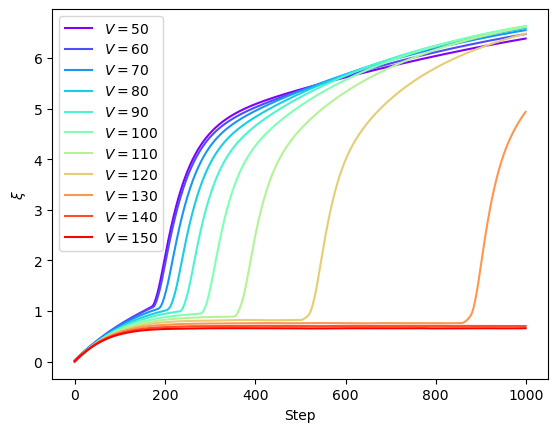

In [25]:
# plot the u-measure for each run, using a different color for each run in a rainbow
plt.figure()
for run_id, run_us in zip(run_ids, all_us):
    plt.plot(steps, run_us, label=f"$V={run_id}$", color=plt.cm.rainbow((int(run_id) - 50) / 100))
plt.legend()
plt.xlabel("Step")
plt.ylabel(r"$\xi$")
plt.show()

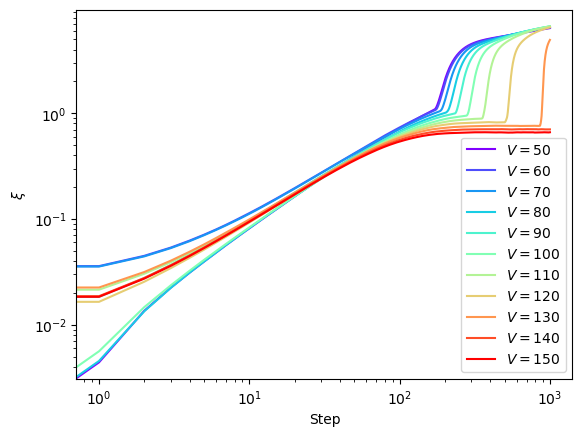

In [26]:
# plot the u-measure for each run again in a similar style, but with a logarithmic y-axis
plt.figure()
for run_id, run_us in zip(run_ids, all_us):
    plt.plot(steps, run_us, label=f"$V={run_id}$", color=plt.cm.rainbow((int(run_id) - 50) / 100))
plt.legend()
plt.xlabel("Step")
plt.ylabel(r"$\xi$")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [29]:
# find the points of maximum derivative for each run
max_derivs = []
for run_us in all_us:
    max_deriv = max(
        (abs(run_us[i + 1] - run_us[i]), i)
        for i in range(len(run_us) - 1)
    )
    max_derivs.append(max_deriv)



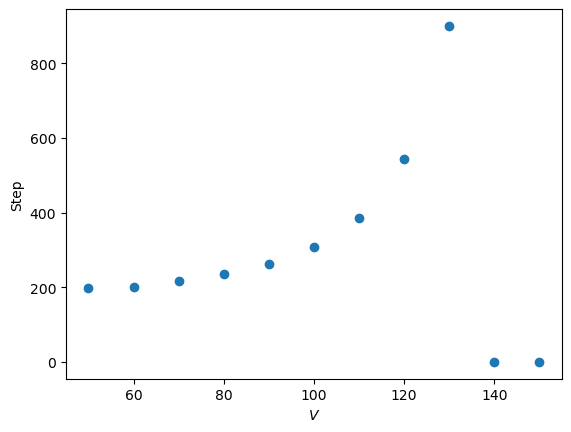

In [34]:
# plot the time to maximum derivative for each run as a scatter plot
plt.figure()
plt.scatter([int(run_id) for run_id in run_ids], [i for _, i in max_derivs])
plt.xlabel("$V$")
plt.ylabel("Step")
plt.show()


In [48]:
import math

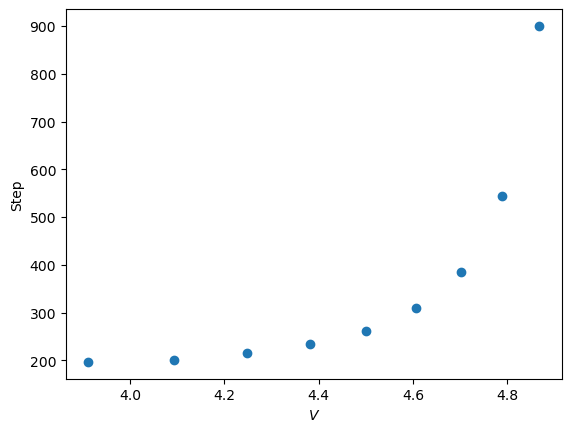

In [49]:
plt.figure()
plt.scatter([math.log(int(run_id)) for run_id in run_ids[:-2]], [`i for _, i in max_derivs[:-2]])
# plt.yscale("log")
plt.xlabel("$V$")
plt.ylabel("Step")
plt.show()

In [50]:
max_derivs

[(0.046530842781066895, 197),
 (0.04587733745574951, 200),
 (0.0454024076461792, 216),
 (0.04562091827392578, 235),
 (0.04602956771850586, 262),
 (0.04728102684020996, 309),
 (0.04952442646026611, 386),
 (0.053874969482421875, 544),
 (0.06060218811035156, 900),
 (0.009253843687474728, 0),
 (0.00912400335073471, 0)]